In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN, PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

In [3]:
# load data
X, y = qg_jets.load(train + val + test)

### Dataset Analysis

In [11]:
print(X.shape)
print(y.shape)

(100000, 139, 4)
(100000,)


- each **jet** (a spray of particles) can contain a different number of particles.
- To store them in a nice uniform format (a 3D array), they use **padding**.
- `max_num_particles` is the **maximum number of particles** any jet in the dataset has.
- If a jet has fewer particles than that, it’s "padded" with **fake zero-particles** to match the shape.
- So each `X[i]` is a list of particles for the i-th jet, and the total shape is: `(num_jets, max_num_particles, 4)`

Each particle inside a jet has:
##### ▪️ `pt` (transverse momentum)
- Think of a particle flying out from a collision.
- `pt` is how **strongly it moves sideways** (in the x–y plane) relative to the beam.
##### ▪️ `y` (rapidity)
- Describes how **fast a particle is moving along the beam direction (z-axis)**.
- Similar to velocity but adapted for high-speed particles.
- In practice, it helps group particles that came from the same collision.
##### ▪️ `phi` (azimuthal angle)
- This is like the **angle on a clock face**, but measured in radians (0 to 2π).
- It tells **where around the beam pipe** the particle flew out.
- Helps us reconstruct the direction of the particle in the detector.
##### ▪️ `pid` (PDG ID)
- This is a **code that tells us what kind of particle it is** (the particle's PDG id: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf).
- Negative numbers are antiparticles.

In [27]:
X

array([[[ 2.68769142e-01,  3.56903171e-01,  4.74138734e+00,
          2.20000000e+01],
        [ 1.60076377e-01, -2.55609533e-01,  4.55022910e+00,
          2.20000000e+01],
        [ 1.14868731e+00, -6.24380156e-02,  4.50385377e+00,
         -2.11000000e+02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00]],

       [[ 1.21266321e+00, -1.12853089e-01,  3.04708757e+00,
         -2.11000000e+02],
        [ 2.40893976e-01, -1.67174886e-02,  2.82705667e+00,
          2.20000000e+01],
        [ 1.02778452e-01, -8.58720522e-02,  3.04180579e+00,
          2.20000000e+01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.000

In [12]:
y

array([1., 1., 1., ..., 1., 0., 0.])

In [25]:
# Print the unique types of particles (pid)

pt = X[..., 0]
pid = X[..., 3]

# Mask out padded particles (where pt == 0)
mask = pt > 0

# Apply the mask to get valid pid values and cast to int
pid_real = pid[mask]

# Get unique values and their counts
unique_pids, counts = np.unique(pid_real, return_counts=True)

# Print top values
for pid_val, count in zip(unique_pids, counts):
    print(f"PID {pid_val}: {count} particles")

PID -2212.0: 67058 particles
PID -2112.0: 66624 particles
PID -321.0: 104245 particles
PID -211.0: 864292 particles
PID -13.0: 986 particles
PID -11.0: 13314 particles
PID 11.0: 13292 particles
PID 13.0: 1047 particles
PID 22.0: 1984333 particles
PID 130.0: 103996 particles
PID 211.0: 868068 particles
PID 321.0: 106935 particles
PID 2112.0: 68135 particles
PID 2212.0: 68580 particles


Class 0.0: 50000 jets (50.00%)
Class 1.0: 50000 jets (50.00%)


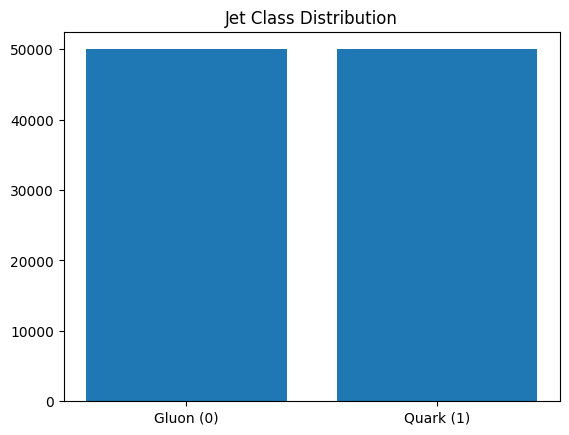

In [13]:
# Check how balanced the dataset is between quark (1) and gluon (0) jets

classes, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(classes, counts):
    print(f"Class {cls}: {cnt} jets ({cnt / len(y) * 100:.2f}%)")

plt.bar(["Gluon (0)", "Quark (1)"], counts)
plt.title("Jet Class Distribution")
plt.show()

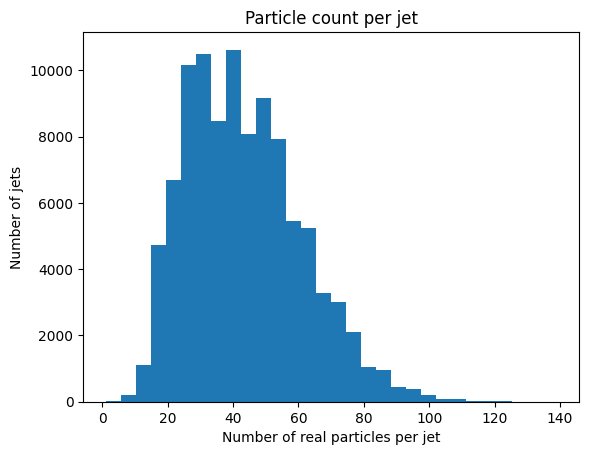

In [15]:
# Count the number of non-padded particles (non-zero pt) in each jet - how "dense" the jets are?

nonzero_counts = np.count_nonzero(X[..., 0], axis=1)  # counting non-zero pt values per jet, because pt=0 indicates a padded (fake) particle

plt.hist(nonzero_counts, bins=30)
plt.xlabel("Number of real particles per jet")
plt.ylabel("Number of jets")
plt.title("Particle count per jet")
plt.show()

- Most graphs (jets) will have 30–60 nodes (particles).
- There’s no huge gap or odd spikes → this distribution looks natural and clean.

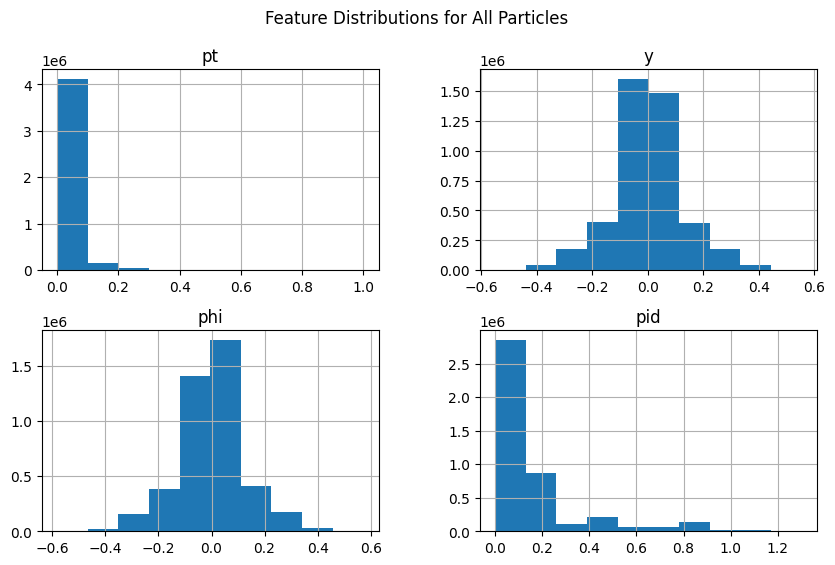

In [17]:
df_particles.hist(figsize=(10, 6))
plt.suptitle("Feature Distributions for All Particles")
plt.show()

- PT:
In real particle jets, many particles are low-energy — they carry very little sideways momentum.
A few particles have higher pt, but they are rare.
- Y: A symmetrical bell-shaped curve centered around 0.
- Phi: Also a centered, symmetrical distribution around 0. Particles are uniformly spread around the circular detector.
- Pid: Strong peak near 0 and then trailing values.

### EFN (Base model)

EFN is a simplified, physics-safe version of PFN:

**Per-particle encoding (ϕ)**

Only based on a particle’s angular information: (η, φ) relative to the jet axis.

No momentum (pT) as input—this ensures infrared and collinear (IRC) safety, meaning the model behaves robustly when low-energy or closely aligned particles are added.

**Energy weighting**

After encoding angles, each particle’s encoding is multiplied by its energy fraction (usually normalized pT). This reintroduces energy information in a linear and safe way.

**Summation and classification (F)**

The weighted encodings are summed, then passed through a classifier network just like PFN.

In [4]:
# ignore pid information
X = X[:,:,:3]

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

Loaded quark and gluon jets


In [5]:
# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

Finished preprocessing


In [6]:
# do train/val/test split
(z_train, z_val, z_test,
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

print('Done train/val/test split')

Done train/val/test split


In [7]:
print('Model summary:')

# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
efn.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=100)

Model summary:


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 phats_input (InputLayer)    [(None, None, 2)]            0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            300       ['phats_input[0][0]']         
                                                                                                  
 activation (Activation)     (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation[0][0]']          
                                                                             

In [8]:
# get ROC curve
efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('EFN AUC:', auc)
print()


EFN AUC: 0.8367077127116207



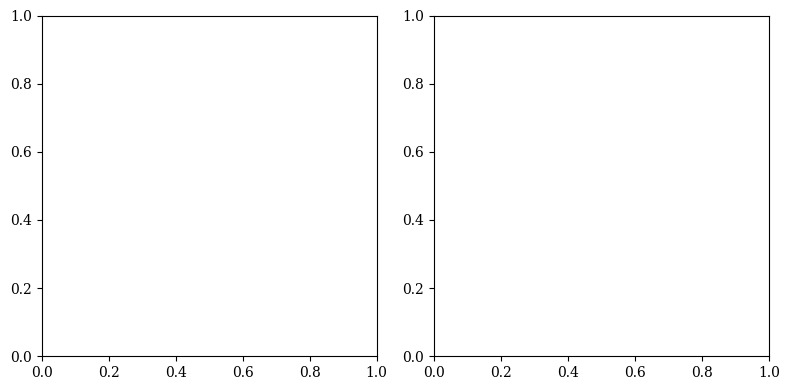

In [9]:
# some nicer plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 2, figsize=(8,4))

In [10]:
######################### ROC Curve Plot #########################

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# plot the ROC curves
axes[0].plot(efn_tp, 1-efn_fp, '-', color='black', label='EFN')
axes[0].plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
axes[0].plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
axes[0].set_xlabel('Quark Jet Efficiency')
axes[0].set_ylabel('Gluon Jet Rejection')

# axes limits
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# make legend and show plot
axes[0].legend(loc='lower left', frameon=False)

# display(fig)

In [12]:
######################### Filter Plot (map of the jet’s internal shape) #########################

# plot settings
R, n = 0.4, 100
colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
grads = np.linspace(0.45, 0.55, 4)

# evaluate filters
X, Y, Z = efn.eval_filters(R, n=n)

# plot filters
for i,z in enumerate(Z):
    axes[1].contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])

axes[1].set_xticks(np.linspace(-R, R, 5))
axes[1].set_yticks(np.linspace(-R, R, 5))
axes[1].set_xticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_yticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_xlabel('Translated Rapidity y')
axes[1].set_ylabel('Translated Azimuthal Angle phi')
axes[1].set_title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})

# plt.show()

Text(0.5, 1.0, 'Energy Flow Network Latent Space')

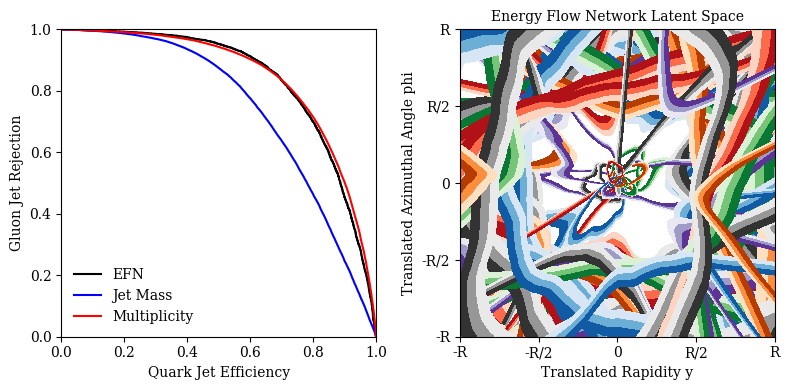

In [13]:
display(fig)

We're calculating:

- **Jet multiplicity**: number of real (non-padded) particles in each jet.

Gluon jets tend to have more particles than quark jets.

So multiplicity is another cheap, physics-based feature that works OK.

- **Jet mass**: total mass of the jet based on its particles’ momenta.

Gluon jets tend to radiate more, creating a wider spray → higher jet mass.

So:

Jet mass is a rough but effective discriminator.

If PFN can't beat it → maybe your model is underperforming.

### PFN

**Per-particle encoding (ϕ)**

Each particle in the jet (node) is transformed individually using a small neural network (like a fully‑connected layer).

Input features include momentum (pT, η, φ), charge, flavor, or pid.

**Summation (permutation-invariant pooling)**

All particle encodings are summed together, producing a single fixed-size vector for the entire jet.

This ensures the model treats the jet as a set, not as an ordered list.

**Jet-level classifier (F)**

A final neural network processes the summed vector to classify the jet (e.g., quark vs. gluon).

So PFN learns: individual particle patterns, sums them up, then decides jet class — flexible and powerful

In [14]:
X, y = qg_jets.load(train + val + test)

In [15]:
# preprocess by centering jets and normalizing pts
use_pids = True

for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
if use_pids:
    remap_pids(X, pid_i=3, error_on_unknown=False)
else:
    X = X[:,:,:3]

print('Finished preprocessing')

Finished preprocessing


In [16]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

In [17]:
# do train/val/test split
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')

Done train/val/test split


In [18]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

Model summary:
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 4)]            0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            500       ['input[0][0]']               
                                                                                                  
 activation_7 (Activation)   (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation_7[0][0]']        
                                                                             

In [19]:
# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.8677472373136876



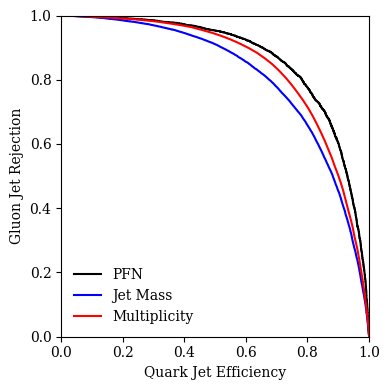

In [20]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()

### PFN with one-hot-encoding of PIDs

In [3]:
X, y = qg_jets.load(train + val + test)

In [4]:
def one_hot_encode_pids(X, pid_to_index, num_pid_types):
    X_new = []

    for jet in X:
        pt = jet[:,0][:, None]  # shape (n, 1)
        yphi = jet[:,1:3]       # shape (n, 2)
        pid = jet[:,3]          # shape (n,)

        # create one-hot encodings
        onehot = np.zeros((jet.shape[0], num_pid_types))
        for i, p in enumerate(pid):
            if p in pid_to_index:
                onehot[i, pid_to_index[p]] = 1

        # combine: pt + yphi + onehot(pid)
        combined = np.concatenate([pt, yphi, onehot], axis=1)
        X_new.append(combined)

    return np.array(X_new)

In [5]:
# handle particle id channel

use_pids = True

for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

if use_pids:
    # Extract unique PID values from the dataset
    pid_vals = np.unique(X[:,:,3][X[:,:,0] > 0])
    pid_to_index = {pid: i for i, pid in enumerate(pid_vals)}
    num_pid_types = len(pid_vals)
    X = one_hot_encode_pids(X, pid_to_index, num_pid_types)
else:
    X = X[:,:,:3]

In [6]:
X

array([[[ 5.36661112e-04,  3.86938282e-01, -8.96080222e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.19630318e-04, -2.25574422e-01, -2.00119039e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.29362569e-03, -3.24029049e-02, -2.46494377e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.28026381e-03, -3.64023862e-01,  1.05785216e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.52971452e-04, -2.67888261e-01, -2.18973045e-01, ...,
          0.00000000e+00,  0.00000000e

In [7]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

In [8]:
# do train/val/test split
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

print('Done train/val/test split')

Done train/val/test split


In [9]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

num_epoch = 15

# train model
pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)

# get predictions on test data
preds = pfn.predict(X_test, batch_size=1000)

Model summary:


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 17)]           0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            1800      ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation[0][0]']          
                                                                             

In [10]:
# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.8745211216549986



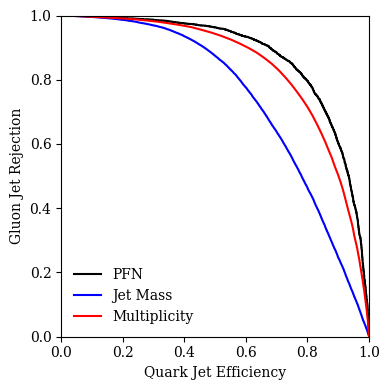

In [11]:
# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# some nicer plot settings
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
plt.plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
plt.plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False)
plt.show()

In [13]:
# import joblib

In [15]:
# with open('pfn_finetune.h5', 'wb') as output_file:
    # joblib.dump(pfn.model, output_file)

In [20]:
# pfn.model.save('pfn_finetune.h5')

In [22]:
pfn.model.save_weights('pfn_finetune_weights.h5')

### Fine tuning

In [61]:
new_pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
new_pfn.model.load_weights('pfn_finetune_weights.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 17)]           0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            1800      ['input[0][0]']               
                                                                                                  
 activation_14 (Activation)  (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation_14[0][0]']       
                                                                                            

In [62]:
X, y = qg_jets.load(num_data=train + val + test, generator='herwig')

In [63]:
def one_hot_encode_pids(X, pid_to_index, num_pid_types):
    X_new = []

    for jet in X:
        pt = jet[:,0][:, None]  # shape (n, 1)
        yphi = jet[:,1:3]       # shape (n, 2)
        pid = jet[:,3]          # shape (n,)

        # create one-hot encodings
        onehot = np.zeros((jet.shape[0], num_pid_types))
        for i, p in enumerate(pid):
            if p in pid_to_index:
                onehot[i, pid_to_index[p]] = 1

        # combine: pt + yphi + onehot(pid)
        combined = np.concatenate([pt, yphi, onehot], axis=1)
        X_new.append(combined)

    return np.array(X_new)

In [64]:
# handle particle id channel

use_pids = True

for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

if use_pids:
    # Extract unique PID values from the dataset
    pid_vals = np.unique(X[:,:,3][X[:,:,0] > 0])
    pid_to_index = {pid: i for i, pid in enumerate(pid_vals)}
    num_pid_types = len(pid_vals)
    X = one_hot_encode_pids(X, pid_to_index, num_pid_types)
else:
    X = X[:,:,:3]

In [65]:
# convert labels to categorical
Y = to_categorical(y, num_classes=2)

In [66]:
# do train/val/test split
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Xtr, Xte, Ytr, Yte = train_test_split(Xz, Yz, test_size=0.2, stratify=Yz, random_state=42)

print('Done train/val/test split')

Done train/val/test split


In [44]:
import tensorflow as tf
import keras

print("model module:", new_pfn.model.__class__.__module__)
print("tf.keras:", tf.keras.__version__)
print("keras:", keras.__version__)

model module: tf_keras.src.engine.functional
tf.keras: 3.11.0
keras: 3.11.0


In [67]:
# freeze early layers (PFN is Phi then F blocks; you may need to inspect layer names)
for layer in new_pfn.model.layers[:9]:   # adjust the slice after checking summary()
    layer.trainable = False

new_pfn.model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# from tf_keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# cbs = [
#     ModelCheckpoint(
#         filepath='pfn_best.weights.h5',           # or 'checkpoints/pfn_best'
#         monitor='val_loss',
#         save_best_only=True,
#         save_weights_only=True,             # <- key bit
#         verbose=1
#     ),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
# ]

# history = new_pfn.model.fit(
#     X_train, Y_train,
#     validation_data=(X_val, Y_val),
#     epochs=15,
#     batch_size=512,
#     callbacks=cbs,
#     verbose=1
# )

In [68]:
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

class SaveBestAUC(Callback):
    def __init__(self, X_val, Y_val, path='pfn_best_auc.ckpt'):
        super().__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.path = path
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        # predict proba for class 1
        probs = self.model.predict(self.X_val, verbose=0)[:, 1]
        auc = roc_auc_score(self.Y_val[:, 1], probs)
        print(f"\nval AUC: {auc:.5f} (best={self.best:.5f})")
        if auc > self.best:
            self.best = auc
            self.model.save_weights(self.path)
            print(f"Saved new best weights to {self.path}")

cbs = [
    SaveBestAUC(X_val, Y_val, path='pfn_best.weights.h5'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
]

history = new_pfn.model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=512,
    callbacks=cbs,
    verbose=1
)

Epoch 1/15
146/147 [============================>.] - ETA: 0s - loss: 0.5387 - accuracy: 0.7338
val AUC: 0.81039 (best=-inf)
Saved new best weights to pfn_best.weights.h5
147/147 [==============================] - 11s 69ms/step - loss: 0.5388 - accuracy: 0.7337 - val_loss: 0.5319 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 2/15
147/147 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.7369
val AUC: 0.80992 (best=0.81039)
147/147 [==============================] - 9s 58ms/step - loss: 0.5343 - accuracy: 0.7369 - val_loss: 0.5300 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 3/15
147/147 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7376
val AUC: 0.81222 (best=0.81039)
Saved new best weights to pfn_best.weights.h5
147/147 [==============================] - 8s 58ms/step - loss: 0.5323 - accuracy: 0.7376 - val_loss: 0.5311 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 4/15
147/147 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.

In [73]:
# get predictions on test data
preds = new_pfn.predict(X_test, batch_size=1000)

15/15 [==============================] - 1s 77ms/step


In [74]:
# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.8132374709248373

